# Imports

In [ ]:
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: ignored

In [ ]:
import os
import pandas as pd

folder_path = '/content/drive/MyDrive/LSTM_results/'

# List to store the dataframes
dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df

FileNotFoundError: ignored

In [ ]:

unique_df = concatenated_df.drop_duplicates()

unique_df

,Ticker,Average RMSE,Std. Dev. RMSE,Average MAPE,Std. Dev. MAPE,Best Model
0,A,5.767298,6.388042,0.046980,0.033730,<keras.src.engine.sequential.Sequential object...
1,AAL,1.881555,0.968092,0.051152,0.023868,<keras.src.engine.sequential.Sequential object...
2,AAPL,5.905118,5.349204,0.052131,0.022615,<keras.src.engine.sequential.Sequential object...
3,ABBV,3.233357,1.405671,0.039141,0.020617,<keras.src.engine.sequential.Sequential object...
4,ABNB,7.933113,2.684885,0.045386,0.018113,<keras.src.engine.sequential.Sequential object...
...,...,...,...,...,...,...
480,WHR,6.714196,2.364824,0.037358,0.006264,<keras.src.engine.sequential.Sequential object...
481,WM,3.138528,1.626817,0.026547,0.003691,<keras.src.engine.sequential.Sequential object...
482,WMB,1.384185,0.678950,0.041890,0.012280,<keras.src.engine.sequential.Sequential object...
483,WMT,4.781609,2.750107,0.037952,0.019094,<keras.src.engine.sequential.Sequential object...


In [ ]:
output_filepath = f'{folder_path}LSTM_results.csv'

unique_df.to_csv(output_filepath, index=False)

In [ ]:
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 0 to 484
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          485 non-null    object 
 1   Average RMSE    485 non-null    float64
 2   Std. Dev. RMSE  485 non-null    float64
 3   Average MAPE    485 non-null    float64
 4   Std. Dev. MAPE  485 non-null    float64
 5   Best Model      485 non-null    object 
dtypes: float64(4), object(2)
memory usage: 26.5+ KB


In [ ]:
pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.5 MB/s eta 0:00:00


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
import requests
import csv
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import math
import warnings
warnings.simplefilter("ignore", UserWarning)
import time

# Analytics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ARIMA libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.arima.model
from pmdarima.arima import auto_arima

# LSTM libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from kerastuner.tuners import RandomSearch
from keras.metrics import RootMeanSquaredError
from kerastuner.engine.hyperparameters import HyperParameter
import kerastuner

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio


Using TensorFlow backend


<ipython-input-5-29f54fc22c12>:39: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data Gathering

## SP500 Tickers

In [ ]:
def save_sp500_tickers():
  # Retrieves S&P 500 table from Wikipedia
  URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
  res = requests.get(URL)
  soup = BeautifulSoup(res.content, 'lxml')
  table = soup.find('table', {'class': 'wikitable sortable'})

  # Parses the table to a list of ticker symbols
  sp500tickers = []

  for row in table.findAll('tr')[1:]:
      ticker = row.findAll('td')[0].text.strip()
      sp500tickers.append(ticker)

  # Writing to csv
  filename = "sp500tickers.csv"
  with open(filename, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Ticker'])
      for ticker in sp500tickers:
          writer.writerow([ticker])

  return sp500tickers

In [ ]:
def load_sp500_tickers():
  path = r'https://raw.githubusercontent.com/jakem08/ms2/main/sp500tickers.csv'
  df = pd.read_csv(path)
  ticker_list = df['Ticker'].tolist()

  return ticker_list


## Stock Data

In [ ]:
def save_stock_data(tickers, start_date, end_date):
  # yahoo finance bulk api call
  data = yf.download(tickers, start=start_date, end=end_date)
  open_df = data.loc[:, 'Open']
  high_df = data.loc[:, 'High']
  low_df = data.loc[:, 'Low']
  close_df = data.loc[:, 'Close']
  adj_close_df = data.loc[:, 'Adj Close']
  volume_df = data.loc[:, 'Volume']

  # yahoo finance individual stock .info
  desc_df = pd.DataFrame()
  for ticker in tqdm(tickers):
    stock_data = yf.Ticker(ticker)
    info = pd.DataFrame([stock_data.info])
    info.index = [ticker]
    desc_df = pd.concat([desc_df,info], axis=0)
    time.sleep(.1)

  # save dataframes to csv
  dataframe_list = [open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df]
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df','desc_df']

  for name, df in zip(names, dataframe_list):
    df.to_csv(f'{name}.csv', index=True)

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df

In [ ]:
def load_stock_data():
  names = ['open_df', 'high_df', 'low_df', 'close_df', 'adj_close_df', 'volume_df', 'desc_df']
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}
  for df in stock_data.values():
        df.fillna(method='ffill', inplace=True)
  open_df = stock_data['open_df']
  high_df = stock_data['high_df']
  low_df = stock_data['low_df']
  close_df = stock_data['close_df']
  adj_close_df = stock_data['adj_close_df']
  volume_df = stock_data['volume_df']
  desc_df = stock_data['desc_df']

  return open_df, high_df, low_df, close_df, adj_close_df, volume_df, desc_df


In [ ]:
def load_results_data():
  names = [
      'gbm_results',
      'arima_results',
      'xgb_results',
      'LSTM_results',
      ]
  stock_data = {name: pd.read_csv(f'https://raw.githubusercontent.com/jakem08/ms2/main/{name}.csv',index_col=0) for name in names}

  gbm_results_df = stock_data['gbm_results']
  gbm_results_df.columns = ['Ticker', 'gbm_avg_RMSE', 'gbm_avg_MAPE']
  gbm_results_df.set_index('Ticker',inplace=True)
  gbm_results_df.index.name = None

  arima_results_df = stock_data['arima_results']
  arima_results_df.columns = ['Ticker', 'arima_avg_RMSE','arima_std_RMSE', 'arima_avg_MAPE', 'arima_std_MAPE', 'arima_model_order']
  arima_results_df.set_index('Ticker',inplace=True)
  arima_results_df.index.name = None

  xgb_results_df = stock_data['xgb_results']
  xgb_results_df.columns = ['xgb_n_estimators','xgb_max_depth',	'xgb_learning_rate','xgb_avg_RMSE','xgb_std_RMSE', 'xgb_avg_MAPE', 'xgb_std_MAPE','xgb_Accuracy']

  lstm_results_df = stock_data['LSTM_results']
  lstm_results_df.columns = ['lstm_avg_RMSE', 'lstm_std_RMSE','lstm_avg_MAPE','lstm_std_MAPE','lstm_model']

  model_results_df = pd.merge(gbm_results_df, arima_results_df, how='inner', left_index=True, right_index=True)
  model_results_df = pd.merge(model_results_df, xgb_results_df, how='inner', left_index=True, right_index=True)
  model_results_df = pd.merge(model_results_df, lstm_results_df, how='inner', left_index=True, right_index=True)

  return model_results_df

model_results_df = load_results_data()
# display(model_results_df)

# load_results_data()

In [ ]:
model_results_df['arima_avg_RMSE'] = model_results_df['arima_avg_RMSE'] * 10
model_results_df['arima_avg_MAPE'] = model_results_df['arima_avg_MAPE'] / 100
model_results_df.to_csv('model_results.csv', index=False)

In [ ]:
RSME_results_df = model_results_df[['gbm_avg_RMSE','arima_avg_RMSE','xgb_avg_RMSE','lstm_avg_RMSE']]
RSME_results_df['RMSE_best_model'] = RSME_results_df.idxmin(axis=1)
RSME_results_df

<ipython-input-56-82c2eb1687c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RSME_results_df['RMSE_best_model'] = RSME_results_df.idxmin(axis=1)


,gbm_avg_RMSE,arima_avg_RMSE,xgb_avg_RMSE,lstm_avg_RMSE,RMSE_best_model
A,8.092,1.424,2.947717,5.767298,arima_avg_RMSE
AAL,4.820,0.226,0.986795,1.881555,arima_avg_RMSE
AAPL,7.814,1.008,1.350246,5.905118,arima_avg_RMSE
ABBV,9.310,3.068,1.264111,3.233357,xgb_avg_RMSE
ABT,4.862,1.528,0.933080,2.935337,xgb_avg_RMSE
...,...,...,...,...,...
OGN,1.745,2.445,1.031798,1.237283,xgb_avg_RMSE
OTIS,7.780,1.480,1.167703,1.831954,xgb_avg_RMSE
CEG,17.490,1.670,1.965999,8.541635,arima_avg_RMSE
GEHC,7.960,1.720,1.359106,8.539388,xgb_avg_RMSE


In [ ]:
MAPE_results_df = model_results_df[['gbm_avg_MAPE','arima_avg_MAPE','xgb_avg_MAPE','lstm_avg_MAPE']]
MAPE_results_df['MAPE_best_model'] = MAPE_results_df.idxmin(axis=1)
MAPE_results_df

<ipython-input-57-466579ff4bd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MAPE_results_df['MAPE_best_model'] = MAPE_results_df.idxmin(axis=1)


,gbm_avg_MAPE,arima_avg_MAPE,xgb_avg_MAPE,lstm_avg_MAPE,MAPE_best_model
A,0.084,0.030266,0.026922,0.046980,xgb_avg_MAPE
AAL,0.152,0.015904,0.029731,0.051152,arima_avg_MAPE
AAPL,0.088,0.040564,0.019526,0.052131,xgb_avg_MAPE
ABBV,0.100,0.035552,0.015979,0.039141,xgb_avg_MAPE
ABT,0.066,0.019798,0.012601,0.033981,xgb_avg_MAPE
...,...,...,...,...,...
OGN,0.050,0.018100,0.037588,0.048323,arima_avg_MAPE
OTIS,0.105,0.037735,0.013980,0.017546,xgb_avg_MAPE
CEG,0.200,0.009560,0.020709,0.077695,arima_avg_MAPE
GEHC,0.090,0.048390,0.015198,0.118323,xgb_avg_MAPE


In [ ]:
MAPE_results_df['MAPE_best_model'].value_counts()

xgb_avg_MAPE      286
arima_avg_MAPE    195
lstm_avg_MAPE       2
Name: MAPE_best_model, dtype: int64

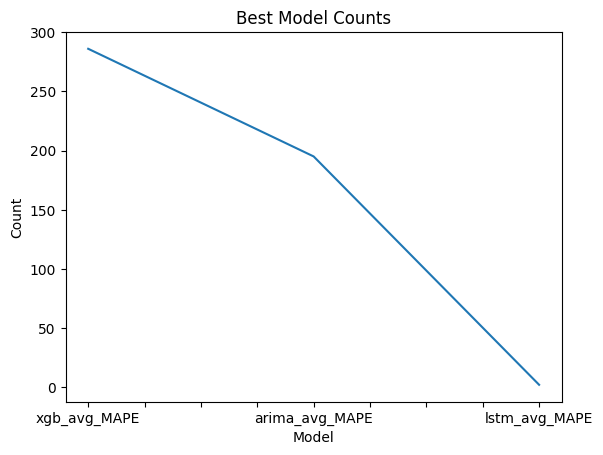

In [ ]:
MAPE_results_df['MAPE_best_model'].value_counts().plot()
plt.xlabel('Model')
plt.ylabel('Count')
plt.title('Best Model Counts')
plt.show()